In [1]:
# Im adding the heart rate into the features extracted using a heuristic function based on these rules 

# Pitch (F0) — higher pitch means higher heart rate
# Energy — louder speech means higher heart rate
# Speaking rate — faster speech means higher heart rate

In [25]:
import numpy as np
import pandas as pd

In [26]:
df = pd.read_csv("speech_features.csv")

In [27]:
pitch_max = np.percentile(df['pitch_mean'], 95)
energy_max = np.percentile(df['energy'], 95)
rate_max = np.percentile(df['speaking_rate'], 95)

print(f"pitch_max ~ {pitch_max:.1f}, energy_max ~ {energy_max:.1f}, rate_max ~ {rate_max:.1f}")

pitch_max ~ 1912.8, energy_max ~ 30.1, rate_max ~ 10.9


In [ ]:
def simulate_heart_rate(row, pitch_max=1912.8, energy_max=30.1, rate_max=10.9, depth_max=1000):
    gender = row.get('gender', 'unknown').lower()
    age = row.get('age', 'unknown').lower()  

    if gender == 'female':
        resting_hr = 64
        pitch_scaling = 4.0
        energy_scaling = 3.0
        rate_scaling = 4.0
        depth_scaling = 2.5
        interaction_scaling = 2.0
        mfcc_scaling = 2.0
        mel_scaling = 2.5
    elif gender == 'male':
        resting_hr = 60
        pitch_scaling = 3.5
        energy_scaling = 2.5
        rate_scaling = 3.5
        depth_scaling = 2.0
        interaction_scaling = 1.8
        mfcc_scaling = 1.8
        mel_scaling = 2.2
    else:
        resting_hr = 62
        pitch_scaling = 3.8
        energy_scaling = 2.8
        rate_scaling = 3.8
        depth_scaling = 2.2
        interaction_scaling = 1.9
        mfcc_scaling = 1.9
        mel_scaling = 2.3

    if age == 'young':
        resting_hr += 3  
        rate_scaling += 0.5
        energy_scaling += 0.3
    elif age == 'mature':
        resting_hr += 0  
    elif age == 'old':
        resting_hr -= 2  
        rate_scaling -= 0.4
        energy_scaling -= 0.2

    mfcc_values = np.array([row[f'mfcc_{i}'] for i in range(1, 14)])
    mfcc_norm = np.clip(np.linalg.norm(mfcc_values) / 100, 0, 1)

    mel_values = np.array([row.get(f'mel_{i}', 0) for i in range(1, 11)])
    mel_norm = np.clip(np.linalg.norm(mel_values) / 50, 0, 1)

    pitch_norm = np.clip(row['pitch_mean'] / pitch_max, 0, 1)
    energy_norm = np.clip(row['energy'] / energy_max, 0, 1)
    rate_norm = np.clip(row['speaking_rate'] / rate_max, 0, 1)
    depth_norm = np.clip(row['pitch_depth'] / depth_max, 0, 1)

    pitch_effect = pitch_scaling * np.tanh(1.5 * pitch_norm)
    energy_effect = energy_scaling * (energy_norm ** 1.2)
    rate_effect = rate_scaling * np.sqrt(rate_norm)
    depth_effect = depth_scaling * (depth_norm ** 0.7)
    interaction = interaction_scaling * pitch_norm * rate_norm
    mfcc_effect = mfcc_scaling * (mfcc_norm ** 1.1)
    mel_effect = mel_scaling * (mel_norm ** 1.1)

    hr = resting_hr + pitch_effect + energy_effect + rate_effect + depth_effect + interaction + mfcc_effect + mel_effect

    noise = np.random.normal(0, 3)  
    hr += noise

    hr = np.clip(hr, 50, 150)
    return hr


In [29]:
df["simulated_hr"] = df.apply(simulate_heart_rate, axis=1)

df.to_csv("speech_features_with_hr.csv", index=False)

print("done.")

done.


In [ ]:
from scipy.stats import mode

df = pd.read_csv("speech_features_with_hr.csv")

male_df = df[df["gender"].str.lower() == "male"]
female_df = df[df["gender"].str.lower() == "female"]

def describe_hr(group, label):
    print(f"\n--- {label.upper()} ---")
    print(f"Count: {len(group)}")
    print(f"Mean HR: {group['simulated_hr'].mean():.2f}")
    print(f"Min HR: {group['simulated_hr'].min():.2f}")
    print(f"Max HR: {group['simulated_hr'].max():.2f}")
    print(f"Range: {group['simulated_hr'].max() - group['simulated_hr'].min():.2f}")
    print(f"Mode HR: {mode(group['simulated_hr'], keepdims=True).mode[0]:.2f}")

describe_hr(male_df, "male")
describe_hr(female_df, "female")


--- MALE ---
Count: 501
Mean HR: 76.35
Min HR: 67.11
Max HR: 86.68
Range: 19.57
Mode HR: 67.11

--- FEMALE ---
Count: 2202
Mean HR: 82.95
Min HR: 68.94
Max HR: 95.11
Range: 26.16
Mode HR: 68.94


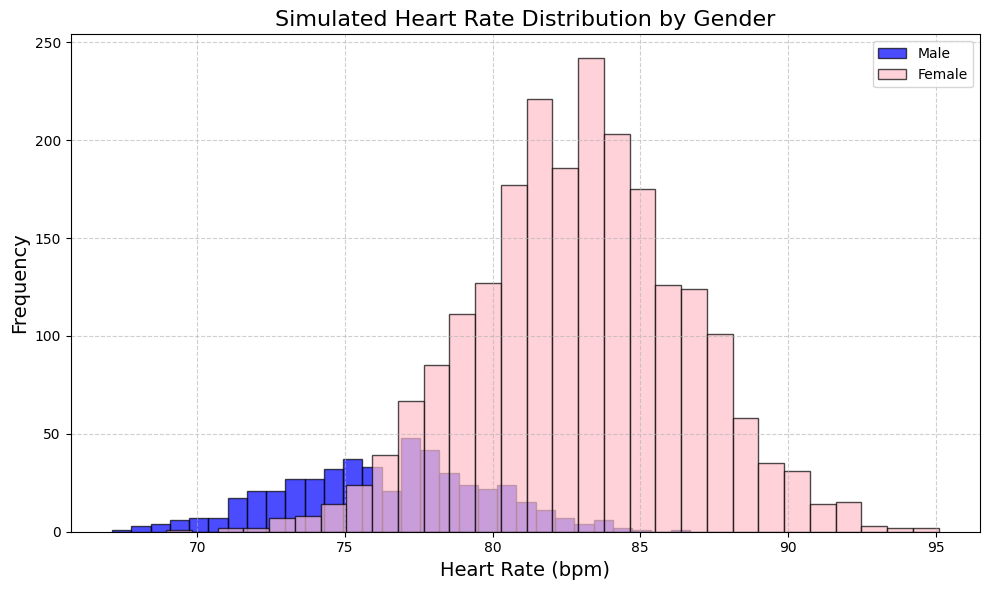

In [ ]:
import matplotlib.pyplot as plt

male_hr = df[df['gender'] == 'male']['simulated_hr']
female_hr = df[df['gender'] == 'female']['simulated_hr']

plt.figure(figsize=(10, 6))
plt.hist(male_hr, bins=30, alpha=0.7, label='Male', color='blue', edgecolor='black')
plt.hist(female_hr, bins=30, alpha=0.7, label='Female', color='pink', edgecolor='black')

plt.title("Simulated Heart Rate Distribution by Gender", fontsize=16)
plt.xlabel("Heart Rate (bpm)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
